In [19]:
import pandas as pd
import joblib
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import (GuideDataset,
                      human_designs,
                      tracr_list)
from core import (get_feature_df,
                  setup_plots)

In [8]:
setup_plots()

In [2]:
model = joblib.load('../models/RuleSet3.pkl')
deweirdt_kwargs = {'filepath': '../data/processed/DeWeirdt2020_activity.csv',
                   'sgrna_seq_col': 'sgRNA Sequence', 'context_seq_col': 'sgRNA Context Sequence',
                   'rank_col': 'scaled_neg_lfc', 'endogenous': True,
                   'sgrna_group_col': 'Target Gene Symbol', 'cut_perc_col': 'Target Cut %',
                   'design_file': human_designs, 'genomewide': True}
sanson_kwargs = {'filepath': '../data/processed/Sanson2018_activity.csv',
                 'sgrna_seq_col': 'sgRNA Sequence', 'context_seq_col': 'sgRNA Context Sequence',
                 'rank_col': 'scaled_neg_lfc', 'endogenous': True,
                 'sgrna_group_col': 'Target Gene Symbol', 'cut_perc_col': 'Target Cut %',
                 'design_file': human_designs, 'genomewide': True}

In [3]:
dataset_list = []
tracr_options = tracr_list
for tracr in tracr_options:
    deweirdt_tracr_kwargs = deweirdt_kwargs.copy()
    deweirdt_tracr_kwargs['tracr'] = tracr
    deweirdt_tracr_kwargs['name'] = 'DeWeirdt2020'
    dataset_list.append(GuideDataset(**deweirdt_tracr_kwargs))
    sanson_tracr_kwargs = sanson_kwargs.copy()
    sanson_tracr_kwargs['tracr'] = tracr
    sanson_tracr_kwargs['name'] = 'Sanson2018'
    dataset_list.append(GuideDataset(**sanson_tracr_kwargs))

In [21]:
dataset_activity_list = []
for ds in dataset_list:
    ds.load_data()
    dataset_activity = ds.get_sg_df(include_group=True,
                                    include_activity=True)
    dataset_activity['dataset'] = ds.name
    dataset_activity['genomewide'] = ds.genomewide
    dataset_activity['tracr'] = ds.tracr
    dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df['dataset_name'] = dataset_activity_df['dataset'].replace(
    {'DeWeirdt2020': 'DeWeirdt 2020 sgRNAs\n(DeWeirdt 2020 tracr)',
     'Sanson2018': 'Sanson 2018 sgRNAs\n(Sanson 2018 tracr)'})
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr,dataset_name
0,AAAAAATTATGCTGAATACC,GATTAAAAAATTATGCTGAATACCAGGTAG,AGG,KPNB1,-0.193618,DeWeirdt2020,True,Hsu2013,DeWeirdt 2020 sgRNAs\n(DeWeirdt 2020 tracr)
1,AAAACAGGGGCACGAGGGTA,AGGAAAAACAGGGGCACGAGGGTATGGATA,TGG,HNRNPU,-0.203537,DeWeirdt2020,True,Hsu2013,DeWeirdt 2020 sgRNAs\n(DeWeirdt 2020 tracr)
2,AAAACCGGCGCTGGAACCAC,GGTCAAAACCGGCGCTGGAACCACGGGACA,GGG,PSMA6,-0.823737,DeWeirdt2020,True,Hsu2013,DeWeirdt 2020 sgRNAs\n(DeWeirdt 2020 tracr)
3,AAAACTATCAAGTTGGGATC,CCAAAAAACTATCAAGTTGGGATCAGGCAG,AGG,SF3B1,-0.559045,DeWeirdt2020,True,Hsu2013,DeWeirdt 2020 sgRNAs\n(DeWeirdt 2020 tracr)
4,AAAACTCTTGGAGCAATATA,CCCAAAAACTCTTGGAGCAATATAAGGAAG,AGG,HNRNPU,1.277651,DeWeirdt2020,True,Hsu2013,DeWeirdt 2020 sgRNAs\n(DeWeirdt 2020 tracr)
...,...,...,...,...,...,...,...,...,...
5677,TTGCTGAACTTGCCGTTGGC,TGACTTGCTGAACTTGCCGTTGGCTGGGTC,TGG,EEF2,-1.569158,Sanson2018,True,Chen2013,Sanson 2018 sgRNAs\n(Sanson 2018 tracr)
5678,TTGGAAATATACATCATAAG,CATTTTGGAAATATACATCATAAGAGGGCC,AGG,EEF2,-0.591832,Sanson2018,True,Chen2013,Sanson 2018 sgRNAs\n(Sanson 2018 tracr)
5679,TTGGGTCTGGCCTCCACGGG,GGCTTTGGGTCTGGCCTCCACGGGTGGGCC,TGG,EEF2,-2.275286,Sanson2018,True,Chen2013,Sanson 2018 sgRNAs\n(Sanson 2018 tracr)
5680,TTTCAGGCCCTTGCGCTTGC,CTTCTTTCAGGCCCTTGCGCTTGCGGGTCT,GGG,EEF2,-1.059545,Sanson2018,True,Chen2013,Sanson 2018 sgRNAs\n(Sanson 2018 tracr)


In [22]:
X = get_feature_df(dataset_activity_df)
dataset_activity_df['Rule Set 3'] = model.predict(X)

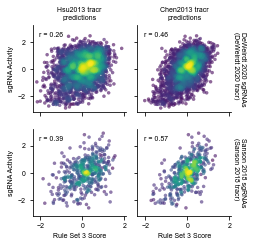

In [25]:
g = sns.FacetGrid(data=dataset_activity_df, col='tracr', row='dataset_name', margin_titles=True,
                  height=1.7)
g.map_dataframe(gpplot.point_densityplot, x='Rule Set 3', y='sgRNA Activity',
                s=10)
g.map_dataframe(gpplot.add_correlation, x='Rule Set 3', y='sgRNA Activity',
                color='black', method='spearman')
g.set_titles(col_template="{col_name} tracr\npredictions", row_template="{row_name}")
g.set_axis_labels(x_var='Rule Set 3 Score', y_var='sgRNA Activity')
plt.subplots_adjust(hspace=0.2)
gpplot.savefig('../figures/seq_alt_tracr_rs3_performance.pdf', dpi=300)